# Ciencia de datos de clasificación

Importar librerías

In [285]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report,roc_auc_score, roc_curve)

Importar datos limpios

In [286]:
df=pd.read_csv("listings_limpio.csv")

# Alistamiento de datos

Visualizar dataframe

In [287]:
df.drop(columns=['id'], inplace=True)
df.shape

(17664, 39)

Definir el target

In [288]:
df['Target']= (df['review_scores_rating']>=4.8).astype(int)

Borrar la variable que se usó para definir el target

In [289]:
df.drop(columns=['review_scores_rating'], inplace=True)

### PREGUNTAR SI BORRO TODOS LOS RATINGS O SOLO EL DEL OBJETIVO

### Ordenar feats

In [290]:
cols_string = df.select_dtypes(include=['object', 'string']).columns.tolist()

In [291]:
cols_bool = df.select_dtypes(include=['bool']).columns.tolist()
df[cols_bool] = df[cols_bool].astype(int)

In [292]:
cols_num = df.select_dtypes(include=['number']).columns.tolist()
cols_num.remove('Target')
cols_bin= [
    c for c in cols_num
    if df[c].dropna().nunique() == 2 and df[c].dropna().isin([0, 1]).all()
]
cols_num=[c for c in cols_num if c not in cols_bin]

In [293]:
feats = cols_num+cols_bin+cols_string
print(len(feats),feats)

38 ['host_response_rate', 'host_acceptance_rate', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'Wifi', 'Air_conditioning', 'Kitchen_and_dining', 'Washer_dryer', 'TV', 'Safe', 'Refrigerator', 'Smoke_alarm_home_safety', 'Essentials', 'Services', 'property_Entire_Place', 'property_Hotel_Room', 'property_Other', 'property_Private_Room', 'property_Shared_Room', 'neighbourhood_cleansed']


In [294]:
df=df[feats+['Target']]

### Separar en train y test

In [295]:
train = df.sample(frac=0.8, random_state=100)
x_train=train.drop(columns=df.columns[-1])
x_train.head()
y_train=train['Target']

In [296]:
test = df.drop(train.index)
x_test=test.drop(columns=df.columns[-1])
x_test.head()
y_test=test['Target']

In [297]:
val = train.sample(frac=0.2, random_state=100)
train = train.drop(val.index)

In [298]:
print(train.shape)
print(val.shape)
print(test.shape)

(11305, 39)
(2826, 39)
(3533, 39)


### Procesar variables de entrada

In [299]:
def dataframe_to_dataset(dataframe, shuffle=True):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    return ds

In [300]:
batch_size = 32

train_ds = dataframe_to_dataset(train, shuffle=True).batch(batch_size)
val_ds   = dataframe_to_dataset(val, shuffle=False).batch(batch_size)
test_ds  = dataframe_to_dataset(test, shuffle=False).batch(batch_size)

In [301]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = keras.layers.Normalization()
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feat_ds)
    return normalizer(feature)

def encode_categorical_feature(feature, name, dataset, is_string=False):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    lookup = lookup_class(output_mode="binary")  
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feat_ds)
    return lookup(feature)

In [302]:
inputs = []
for i in cols_num:
  inputs.append(keras.Input(shape=(1,), name=i))

for i in cols_bin:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

for i in cols_string:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [303]:
feats_encoded=[]
len_feats=len(feats_encoded)
for i,feat in enumerate(cols_num):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_bin):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, False)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_string):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

all_feats = keras.layers.concatenate(feats_encoded)

## Red neuronal de clasificación

### Contruir modelo

In [304]:
model_layers = keras.layers.Dense(32, activation='relu')(all_feats)
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)
model = keras.Model(inputs, model_layers)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [305]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [306]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

### Entrenar modelo

In [307]:
history = model.fit(
    train_ds,
    epochs=60,
    validation_data=val_ds,
    callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
)

Epoch 1/60
354/354 [==============================] - 3s 4ms/step - loss: 0.3975 - accuracy: 0.8295 - val_loss: 0.2877 - val_accuracy: 0.8992
Epoch 2/60
354/354 [==============================] - 1s 3ms/step - loss: 0.2651 - accuracy: 0.9016 - val_loss: 0.2641 - val_accuracy: 0.9020
Epoch 3/60
354/354 [==============================] - 1s 3ms/step - loss: 0.2441 - accuracy: 0.9076 - val_loss: 0.2558 - val_accuracy: 0.9030
Epoch 4/60
354/354 [==============================] - 1s 3ms/step - loss: 0.2318 - accuracy: 0.9096 - val_loss: 0.2493 - val_accuracy: 0.9009
Epoch 5/60
354/354 [==============================] - 1s 3ms/step - loss: 0.2231 - accuracy: 0.9121 - val_loss: 0.2508 - val_accuracy: 0.9009
Epoch 6/60
354/354 [==============================] - 1s 3ms/step - loss: 0.2168 - accuracy: 0.9143 - val_loss: 0.2457 - val_accuracy: 0.9034
Epoch 7/60
354/354 [==============================] - 1s 3ms/step - loss: 0.2128 - accuracy: 0.9148 - val_loss: 0.2470 - val_accuracy: 0.9052
Epoch 

### Metricas

Historial de pérdida

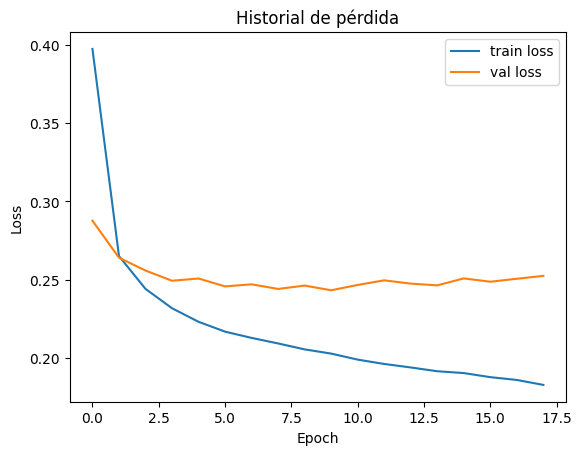

In [308]:
# Pérdida
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Historial de pérdida")
plt.legend(); plt.show()


Predicción

In [309]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob>0.5).astype(int)
y_pred
y_pred.shape

111/111 [==============================] - 1s 3ms/step


(3533, 1)

Metricas

111/111 [==============================] - 0s 3ms/step
Accuracy : 0.9054627795075008
Precision: 0.9049410356856218
Recall   : 0.9054627795075008
F1       : 0.9049353530171118
ROC-AUC  : 0.8914753492176656

Matriz de confusión:
 [[2143  138]
 [ 196 1056]]

Reporte de clasificación:
                 precision    recall  f1-score   support

no-recomendado       0.92      0.94      0.93      2281
   recomendado       0.88      0.84      0.86      1252

      accuracy                           0.91      3533
     macro avg       0.90      0.89      0.90      3533
  weighted avg       0.90      0.91      0.90      3533

Especificidad(TNR): 0.9395
Error tipo I (FPR): 0.0605
Error tipo II(FNR): 0.1565


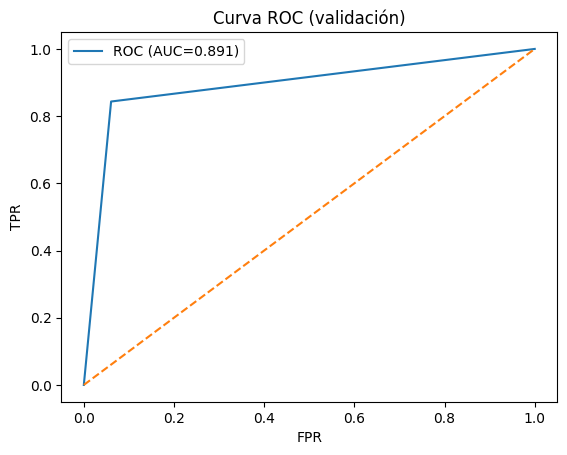

In [310]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob>0.5).astype(int).flatten()
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

acc  = accuracy_score(y_true,y_pred)
prec = precision_score(y_true,y_pred, average='weighted', pos_label=1)
rec  = recall_score(y_true,y_pred, pos_label=1,average='weighted')
f1   = f1_score(y_true,y_pred, pos_label=1,average='weighted')
cm   = confusion_matrix(y_true,y_pred)
report = classification_report(y_true,y_pred, target_names=["no-recomendado","recomendado"])

tn, fp, fn, tp = confusion_matrix(y_true,y_pred, labels=[0,1]).ravel()
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0      
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0 
# ROC-AUC (prob de la clase positiva = columna 1)
auc  = roc_auc_score(y_true,y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC-AUC  :", auc)
print("\nMatriz de confusión:\n", cm)
print("\nReporte de clasificación:\n", report)
print(f"Especificidad(TNR): {tnr:.4f}")
print(f"Error tipo I (FPR): {fpr:.4f}")
print(f"Error tipo II(FNR): {fnr:.4f}")

# ===== 5) Curva ROC (opcional en el reporte) =====
fpr, tpr, thr = roc_curve(y_true,y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC (validación)")
plt.legend(); plt.show()